In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
from pyspark.sql import functions as F, Window
from manga_recsys.spark import get_spark

spark = get_spark()

In [2]:
manga_info = spark.read.parquet(
    "../data/processed/2022-12-17-metadata-listing/manga_info.parquet"
)
manga_info.printSchema()
manga_info.show(1, vertical=True, truncate=80)

root
 |-- id: string (nullable = true)
 |-- createdAt: string (nullable = true)
 |-- updatedAt: string (nullable = true)
 |-- availableTranslatedLanguages: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- originalLanguage: string (nullable = true)
 |-- publicationDemographic: string (nullable = true)
 |-- status: string (nullable = true)
 |-- year: long (nullable = true)
 |-- contentRating: string (nullable = true)
 |-- name: string (nullable = true)
 |-- chapter_count: long (nullable = true)
 |-- page_count: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- group: string (nullable = true)
 |    |    |-- name: string (nullable = true)

-RECORD 0--------------------------------------------------------------------------------------------------------
 id                           | 005b434a-f5ba-49cc-8a97-549ae4a386c6                                

* https://spark.apache.org/docs/latest/ml-features.html#word2vec
* https://radimrehurek.com/gensim/models/word2vec.html
* https://stackoverflow.com/questions/66267818/minimum-number-of-words-in-the-vocabulary-for-word2vec-models

After taking a look at a few of these, it looks like I want a CBOW word2vec model to capture the distributional semantics of the tags.
It'd be much simpler if I could just use the word2vec model from PySpark to stay within the same ecosystem, but it doesn't look possible.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

tag_counts = (
    manga_info.select("id", F.explode("tags").alias("tag"))
    .groupBy("tag.group", "tag.name")
    .agg(F.countDistinct("id").alias("n"))
    .orderBy(F.desc("n"))
    .toPandas()
)
tag_counts

,group,name,n
0,genre,Romance,25827
1,genre,Comedy,22401
2,genre,Drama,19622
3,format,Oneshot,14874
4,genre,Slice of Life,13781
...,...,...,...
71,theme,Zombies,303
72,theme,Virtual Reality,226
73,theme,Ninja,215
74,theme,Traditional Games,133


In [4]:
tag_counts.groupby("group").count().sort_values("n", ascending=False)

,name,n
group,,
theme,37,37
genre,25,25
format,12,12
content,2,2


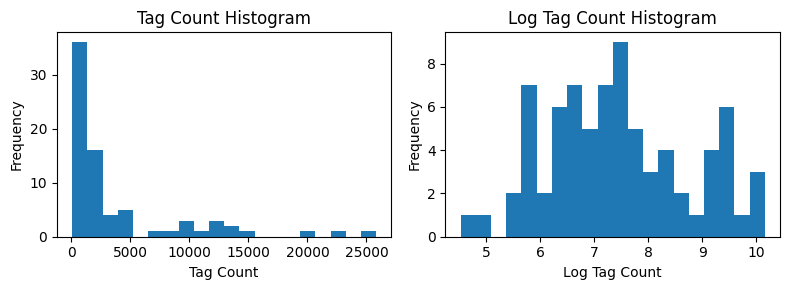

In [5]:
# create two side-by-side plots of tag count histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.hist(tag_counts["n"], bins=20)
ax1.set_title("Tag Count Histogram")
ax1.set_xlabel("Tag Count")
ax1.set_ylabel("Frequency")

ax2.hist(np.log(tag_counts["n"]), bins=20)
ax2.set_title("Log Tag Count Histogram")
ax2.set_xlabel("Log Tag Count")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [6]:
manga_tags = (
    manga_info.select("id", F.explode("tags").alias("tag"))
    .groupBy("id")
    .agg(F.collect_list("tag.name").alias("tags"))
    .orderBy("id")
    .toPandas()
)
manga_tags.head()

,id,tags
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]"
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]"
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]"
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]"
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ..."


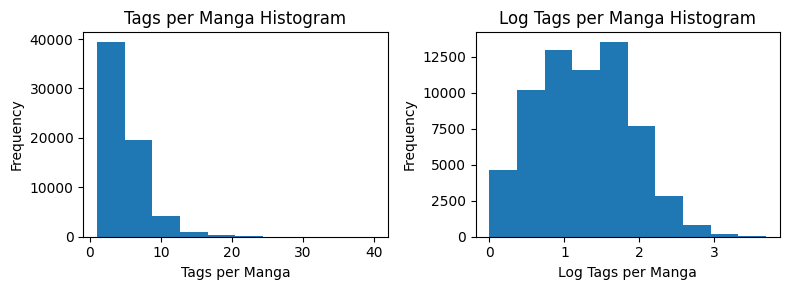

In [7]:
# plot the histogram of tags per manga, and the log of that
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.hist(manga_tags["tags"].apply(len), bins=10)
ax1.set_title("Tags per Manga Histogram")
ax1.set_xlabel("Tags per Manga")
ax1.set_ylabel("Frequency")

ax2.hist(np.log(manga_tags["tags"].apply(len)), bins=10)
ax2.set_title("Log Tags per Manga Histogram")
ax2.set_xlabel("Log Tags per Manga")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [8]:
from gensim.models import Word2Vec

# continuous bag of words
sentences = [list(x) for x in manga_tags.tags.tolist()]
model = Word2Vec(sentences, sg=0, vector_size=16, workers=4)

In [9]:
model.wv.most_similar("Isekai")

[('Villainess', 0.8715243339538574),
 ('Adaptation', 0.8288401961326599),
 ('Magic', 0.8167899250984192),
 ('Reincarnation', 0.75880366563797),
 ('Harem', 0.7432475686073303),
 ('Fantasy', 0.7145391702651978),
 ('Reverse Harem', 0.6835432052612305),
 ('Virtual Reality', 0.6678503155708313),
 ('Wuxia', 0.6656720638275146),
 ('Video Games', 0.6413357853889465)]

In [10]:
# use tag count names to get a matrix of tag vectors
tag_vectors = np.array([model.wv[tag] for tag in tag_counts["name"]])
tag_vectors.shape

(76, 16)

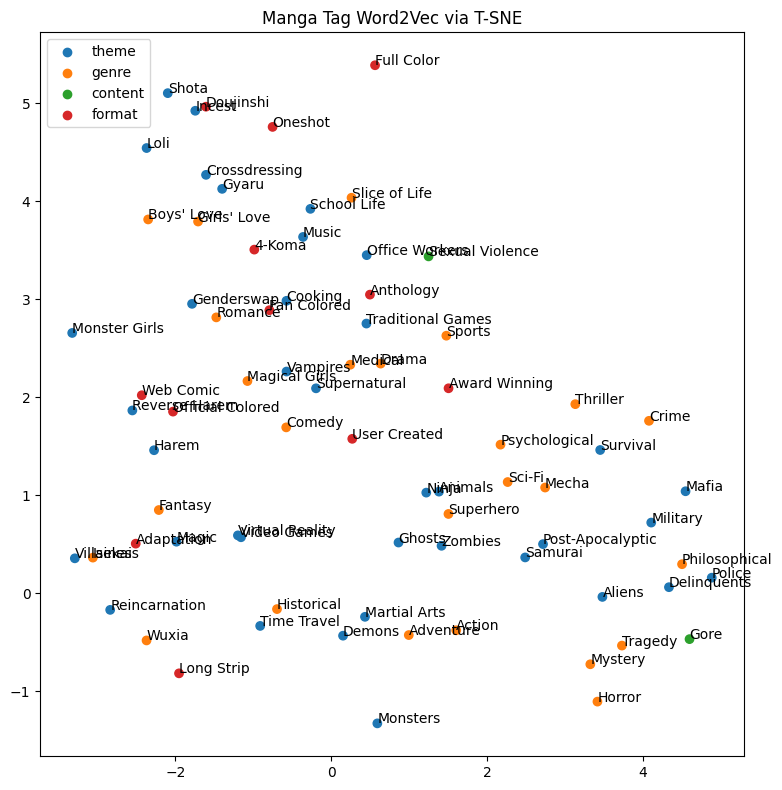

In [11]:
# plot the manga tag vectors and label each dot with the tag name
# color each of the tags by their group
from sklearn.manifold import TSNE

# create a color map for each group: genre, format, content, theme
# use a color pallette by default
group_colors = {
    "theme": "tab:blue",
    "genre": "tab:orange",
    "content": "tab:green",
    "format": "tab:red",
}

tsne = TSNE(n_components=2, random_state=0)
tag_vectors_2d = tsne.fit_transform(tag_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    tag_vectors_2d[:, 0], tag_vectors_2d[:, 1], c=tag_counts["group"].map(group_colors)
)
# show which color maps to each
for group, color in group_colors.items():
    ax.scatter([], [], c=color, label=group)

# now annotate
for i, tag in enumerate(tag_counts["name"]):
    ax.annotate(tag, (tag_vectors_2d[i, 0], tag_vectors_2d[i, 1]))

ax.set_title("Manga Tag Word2Vec via T-SNE")
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

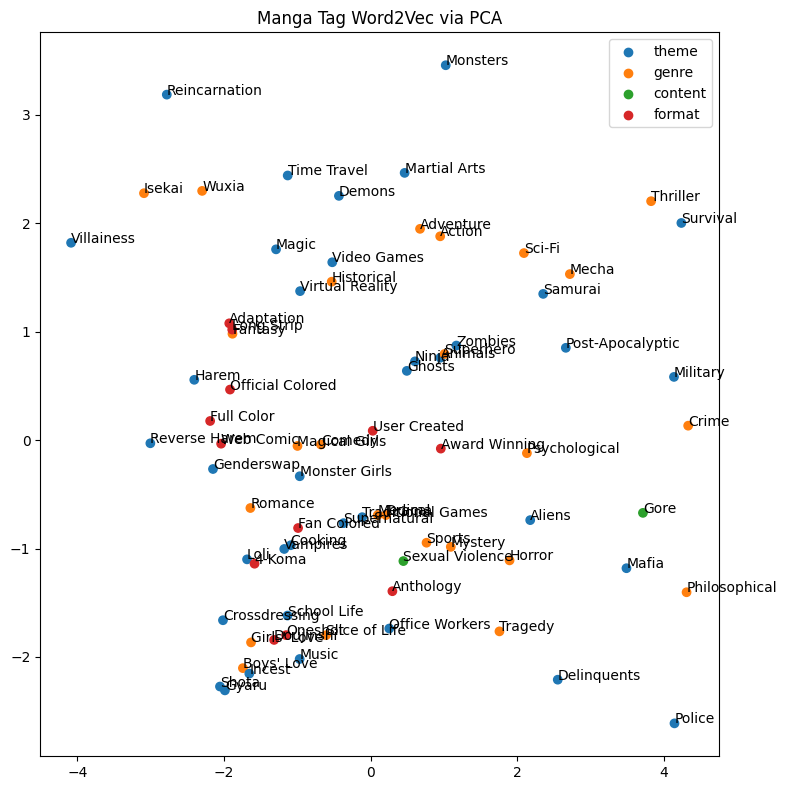

In [12]:
# make the same plot, but use PCA this time
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
tag_vectors_2d = pca.fit_transform(tag_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    tag_vectors_2d[:, 0], tag_vectors_2d[:, 1], c=tag_counts["group"].map(group_colors)
)
# show which color maps to each
for group, color in group_colors.items():
    ax.scatter([], [], c=color, label=group)

# now annotate
for i, tag in enumerate(tag_counts["name"]):
    ax.annotate(tag, (tag_vectors_2d[i, 0], tag_vectors_2d[i, 1]))

ax.set_title("Manga Tag Word2Vec via PCA")
ax.legend()
plt.tight_layout()
plt.show()

f:\code\mangadex\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


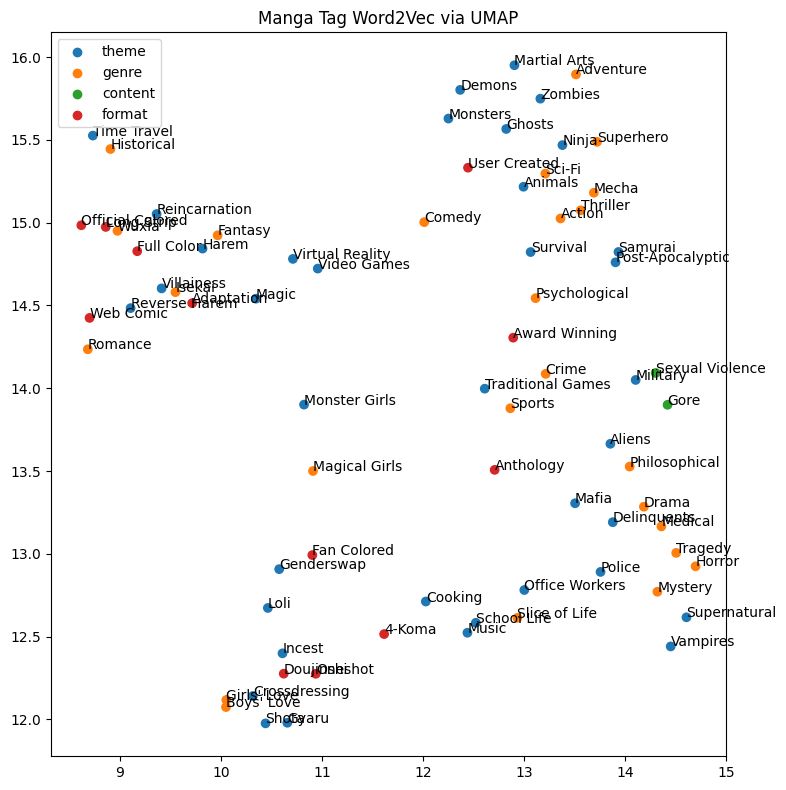

In [13]:
# now one last time but with umap
import umap

reducer = umap.UMAP(n_components=2, random_state=0, metric="cosine")
tag_vectors_2d = reducer.fit_transform(tag_vectors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    tag_vectors_2d[:, 0], tag_vectors_2d[:, 1], c=tag_counts["group"].map(group_colors)
)

# show which color maps to each
for group, color in group_colors.items():
    ax.scatter([], [], c=color, label=group)

# now annotate
for i, tag in enumerate(tag_counts["name"]):
    ax.annotate(tag, (tag_vectors_2d[i, 0], tag_vectors_2d[i, 1]))

ax.set_title("Manga Tag Word2Vec via UMAP")
# legend in top left
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()